In [1]:
import numpy as np
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
import phidl.geometry as pg
import pprint

In [2]:
wafer_radius = 50.8*1e3 # 4-inch
n_gridline = 20

# Wafer design

In [3]:
wafer = Device('wafer')
circle = pg.circle(radius = wafer_radius, angle_resolution = 2.5, layer = 21)
inv_circle = pg.invert(circle, border = 7000, precision = 1e-6, layer = 21)
wafer.add_ref( inv_circle )
# qp(wafer)

DeviceReference (parent Device "boolean", ports [], origin (0, 0), rotation 0, x_reflection False)

# Chip design

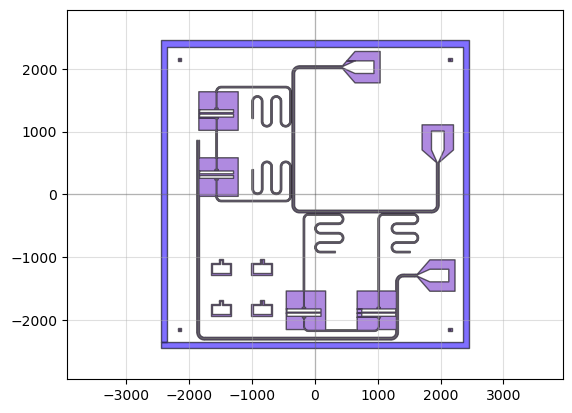

In [4]:
# Import the GDS file into a PHIDL Device
gds_file = "../module/2D_with_dcline.gds"
imported_device = pg.import_gds(gds_file)

FM=Device('frame')
rectangle = pg.rectangle((4700, 4700), 25)
FM.add_ref( pg.invert(rectangle, border = 100, precision = 1e-6, layer = 25) )
FM.center = (0, 0)
imported_device.add_ref( FM )
# Quickplot the imported design
qp(imported_device)

# Josephson Junction (Manhattan with bandage)

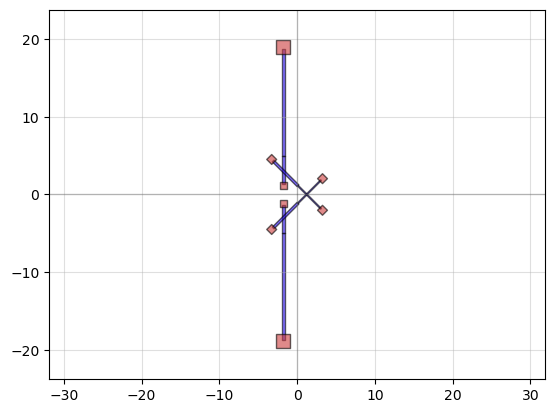

In [5]:
def device_JJ( width = 0.135):
    JJ=Device('JJ')
    JJ_half=Device('JJ_half')

    finger_layer = 1
    box_layer = 2
    box_finger_overlay_outer = 0.68
    box_finger_overlay_inner = 0.18

    box_outer_width = 1.8
    finger_width_outer1 = 0.405
    finger_length_outer1 = 13.7

    finger_width_outer2 = 0.315
    finger_length_outer2 = 3.6

    finger_width_inner1 = 0.315
    finger_length_inner1 = 4.5

    finger_width_inner2 = width
    finger_length_inner2 = 4.2

    box_inner_width = 0.9

    box_outer = pg.rectangle((box_outer_width, box_outer_width), box_layer)
    box_outer.movex(-box_outer.center[0])
    box_outer.add_port(name = 'out', midpoint = [0, box_finger_overlay_outer], width = finger_width_outer1, orientation = 270)
    # rectangle_subtract = pg.rectangle((finger_width_outer1, box_finger_overlay_outer), box_layer)
    # rectangle_subtract.movex(-rectangle_subtract.center[0])
    # box_outer = pg.boolean(A = box_outer, B = rectangle_subtract, operation = 'not', precision = 1e-6, num_divisions = [1,1], layer = box_layer)

    # finger
    finger_outer1 = pg.rectangle((finger_width_outer1, finger_length_outer1), finger_layer)
    finger_outer1.movex(-finger_outer1.center[0])
    finger_outer1.add_port(name = 'in', midpoint = [0, finger_length_outer1], width = finger_width_outer1, orientation = 90)
    finger_outer1.add_port(name = 'out', midpoint = [0, 0], width = finger_width_outer1, orientation = 270)

    finger_outer2 = pg.rectangle((finger_width_outer2, finger_length_outer2), finger_layer)
    finger_outer2.movex(-finger_outer2.center[0])
    finger_outer2.add_port(name = 'in', midpoint = [0, finger_length_outer2], width = finger_width_outer2, orientation = 90)
    finger_outer2.add_port(name = 'out', midpoint = [0, 0], width = finger_width_outer2, orientation = 270)

    finger_inner1 = pg.rectangle((finger_width_inner1, finger_length_inner1), finger_layer)
    finger_inner1.movex(-finger_inner1.center[0])
    finger_inner1.add_port(name = 'in', midpoint = [0, finger_length_inner1], width = finger_width_inner1, orientation = 90)
    finger_inner1.add_port(name = 'out', midpoint = [0, 0], width = finger_width_inner1, orientation = 270)

    finger_inner2 = pg.rectangle((finger_width_inner2, finger_length_inner2), finger_layer)
    finger_inner2.movex(-finger_inner2.center[0])
    finger_inner2.add_port(name = 'in', midpoint = [0, finger_length_inner2], width = finger_width_inner2, orientation = 90)
    finger_inner2.add_port(name = 'out', midpoint = [0, 0], width = finger_width_inner2, orientation = 270)

    # inner box (x 3)
    box_inner = pg.rectangle((box_inner_width, box_inner_width), box_layer)
    box_inner.movex(-box_inner.center[0])
    box_inner.add_port(name = 'out', midpoint = [0, box_finger_overlay_inner], width = finger_width_inner1, orientation = 270)

    box_outer = JJ_half.add_ref( box_outer )
    finger_outer1 = JJ_half.add_ref( finger_outer1 )
    finger_outer2 = JJ_half.add_ref( finger_outer2 )
    box_inner1 = JJ_half.add_ref( box_inner )
    box_inner1.rotate(180)

    box_inner2 = JJ_half.add_ref( box_inner )
    box_inner2.rotate(45)
    box_inner2.center = (-1.5, -13.5)
    finger_inner1 = JJ_half.add_ref( finger_inner1 )
    finger_inner2 = JJ_half.add_ref( finger_inner2 )
    box_inner3 = JJ_half.add_ref( box_inner )

    finger_outer1.connect(port = 'in', destination = box_outer.ports['out'])
    finger_outer2.connect(port = 'in', destination = finger_outer1.ports['out'])
    box_inner1.connect(port = 'out', destination = finger_outer2.ports['out'])

    finger_inner1.connect(port = 'in', destination = box_inner2.ports['out'])
    finger_inner2.connect(port = 'in', destination = finger_inner1.ports['out'])
    box_inner3.connect(port = 'out', destination = finger_inner2.ports['out'])

    JJ.add_ref( JJ_half )
    JJ.add_ref( pg.copy(JJ_half).mirror(p1 = (-5, -18), p2 = (5, -18)) ) 
    JJ.center = (0,0)
    return JJ

JJ = device_JJ(width = 0.135)
qp(JJ)

# Add JJ to chip design

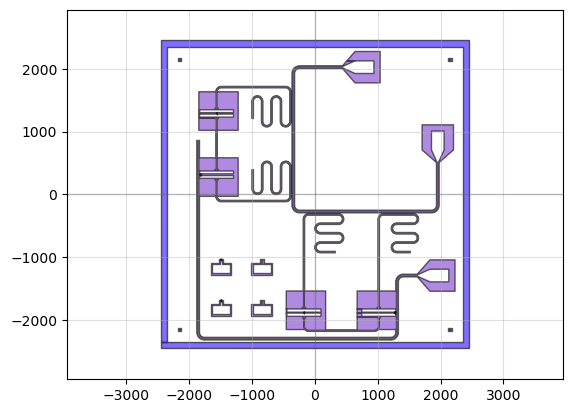

'output/chipdesign.gds'

In [6]:
def custom_chip(width, height):
    chip = Device('chip')
    chip.add_ref(imported_device)
    JJ = device_JJ(width = width)

    # SQUID
    chip.add_ref(JJ).movex(1280).movey(-1880)
    chip.add_ref(JJ).movex(1270).movey(-1880)
    # transmon
    chip.add_ref(JJ).movex(-172).movey(-1880)
    # SQUID
    chip.add_ref(JJ).movex(-1825).movey(315)
    chip.add_ref(JJ).movex(-1815).movey(315)
    # transmon
    chip.add_ref(JJ).movex(-1560).movey(1290)

    # transmon (test)
    chip.add_ref(JJ).movex(-1493).movey(-1689)
    chip.add_ref(JJ).movex(-1493).movey(-1038)

    return chip

chip = custom_chip(width = 0.135, height = None)
qp(chip)
chip.write_gds('output/chipdesign')

# Place chip designs

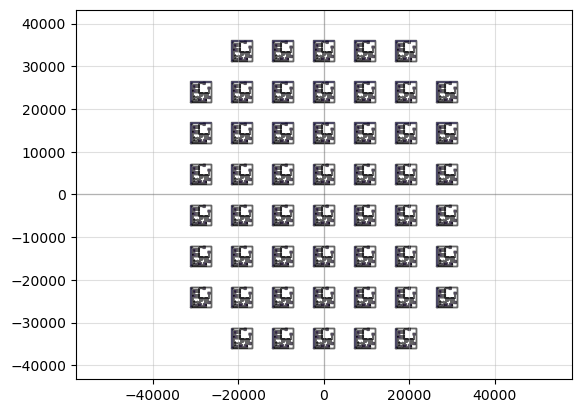

In [7]:


D = pg.gridsweep(
    function = custom_chip,
    param_x = {'width' :  [0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165]},
    param_y = {'height' : [10, 10, 10, 10, 10, 10, 10, 10]},
    spacing = (4700,4700),
    label_layer = None
    )
D.center = (0,0)
# D = D.movex(-6*4800).movey(-7*4800)
# pprint.pprint(D.references)

## Remove corners
xmin = min([ref.center[0] for ref in D.references])
xmax = max([ref.center[0] for ref in D.references])
ymin = min([ref.center[1] for ref in D.references])
ymax = max([ref.center[1] for ref in D.references])
for ref in D.references:
    # print( ref.center )
    # print( ref.size )
    if (ref.center == (xmin, ymin)).all() or (ref.center == (xmax, ymin)).all() or (ref.center == (xmin, ymax)).all() or (ref.center == (xmax, ymax)).all():
        D.remove(ref)
wafer.add_ref(D)
qp(D)


# Add EB markers

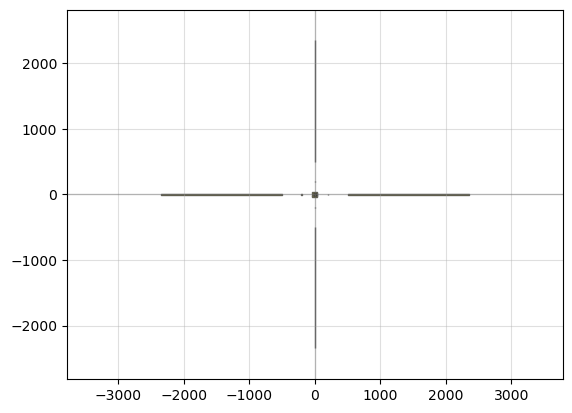

In [8]:
def device_EBmarker(layer = 3):

    EBmarker = Device("EBmarker")
    markers = {}
    tmp1 = pg.bbox([(-5,-20), (5,20)])
    tmp2 = pg.bbox([(-20,-5), (20,5)])
    markers["EBr1"] = pg.boolean(tmp1, tmp2, 'or', layer = layer)
    tmp1 = pg.bbox([(-40,-40), (40,40)])
    tmp2 = pg.bbox([(-30,-30), (30,30)])
    markers["EBr2"] = pg.boolean(tmp1, tmp2, 'not', layer = layer)

    markers["EBf1"] = pg.rectangle((10,10), layer)
    markers["EBf1"].move((-5,-5-200))
    markers["EBf2"] = pg.copy(markers["EBf1"]).rotate(90)
    markers["EBf3"] = pg.copy(markers["EBf1"]).rotate(180)
    markers["EBf4"] = pg.copy(markers["EBf1"]).rotate(270)


    markers["guide1"] = pg.rectangle((10,1850), layer)
    markers["guide1"].move((-5,500))
    markers["guide2"] = pg.copy(markers["guide1"]).rotate(90)
    markers["guide3"] = pg.copy(markers["guide1"]).rotate(180)
    markers["guide4"] = pg.copy(markers["guide1"]).rotate(270)

    # markers["EB_EPFL1"] = pg.rectangle((20,20), layer)
    # markers["EB_EPFL1"].move((-10,-10-2900))
    # markers["EB_EPFL2"] = pg.copy(markers["EB_EPFL1"]).rotate(90)
    # markers["EB_EPFL3"] = pg.copy(markers["EB_EPFL1"]).rotate(180)
    # markers["EB_EPFL4"] = pg.copy(markers["EB_EPFL1"]).rotate(270)

    for key in markers.keys():
        EBmarker.add_ref(markers[key])

    qp(EBmarker)

    return EBmarker

EBmarker = device_EBmarker(layer = 3)
marker_pos = [(0,0),(0,38400),(-19200,-28800),(38400,0),
              (0,-38400),(-19200,-38400),(-38400,0)]

for ii in range(len(marker_pos)):
    marker = wafer.add_ref(EBmarker)
    marker.center = marker_pos[ii]

# Add grid lines

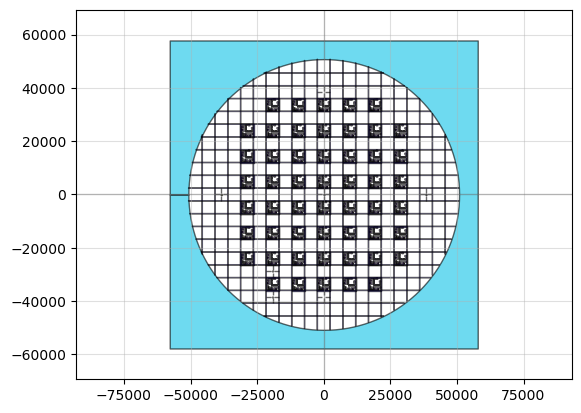

In [9]:

device_list = [pg.rectangle(size = (100, 2*wafer_radius), layer = 25) for i in range(n_gridline)]
grid = pg.grid(device_list,
            spacing = (4800,0),
            separation = False,
            shape = (n_gridline,1))
grid.center = (0, 0)
grid = pg.boolean(A = grid, B = inv_circle, operation = 'not', precision = 1e-6,
               num_divisions = [1,1], layer = 25)

wafer.add_ref( grid )
wafer.add_ref( pg.copy(grid).rotate(90) )

qp(wafer)


In [10]:
wafer.write_gds('output/test')

'output/test.gds'